# Milestone 2

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scripts import *

### I. Data Prepration

In [3]:
# Read the data
data_path = './data'  
images, labels = data_reader(data_path)

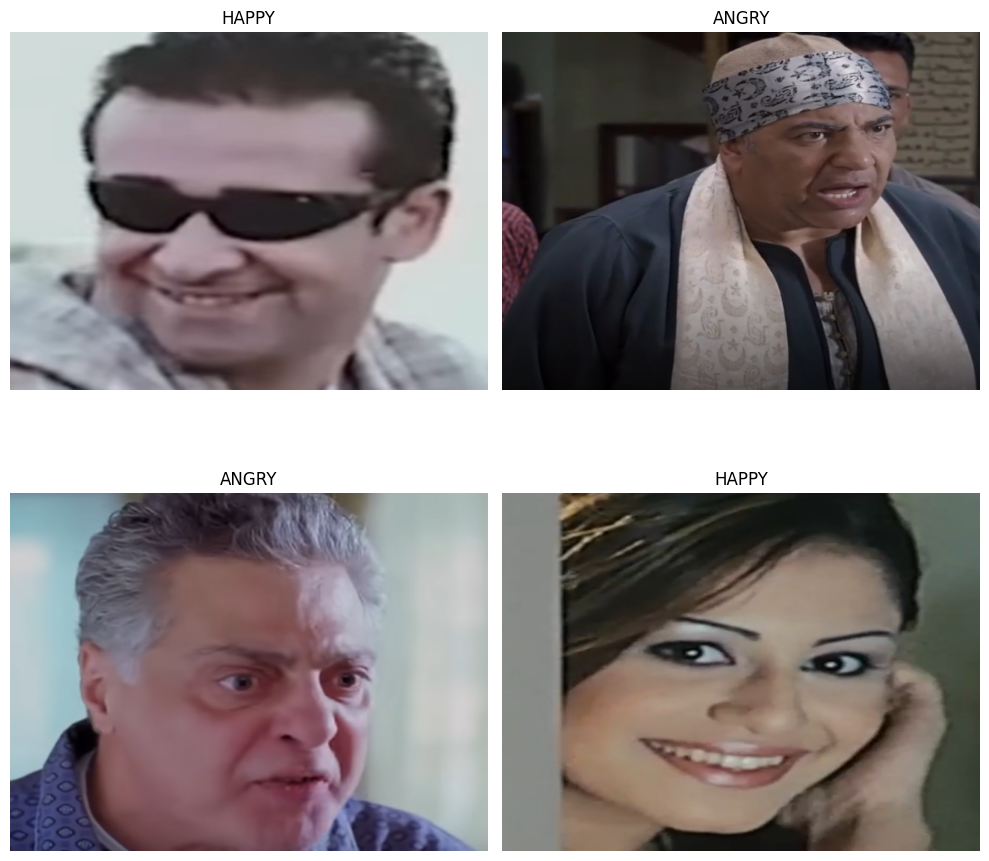

In [ ]:
# View 4 random images and their titles
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple = data_preperator((images, labels))

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((318, 512, 512, 3),
 (318,),
 (91, 512, 512, 3),
 (91,),
 (46, 512, 512, 3),
 (46,))